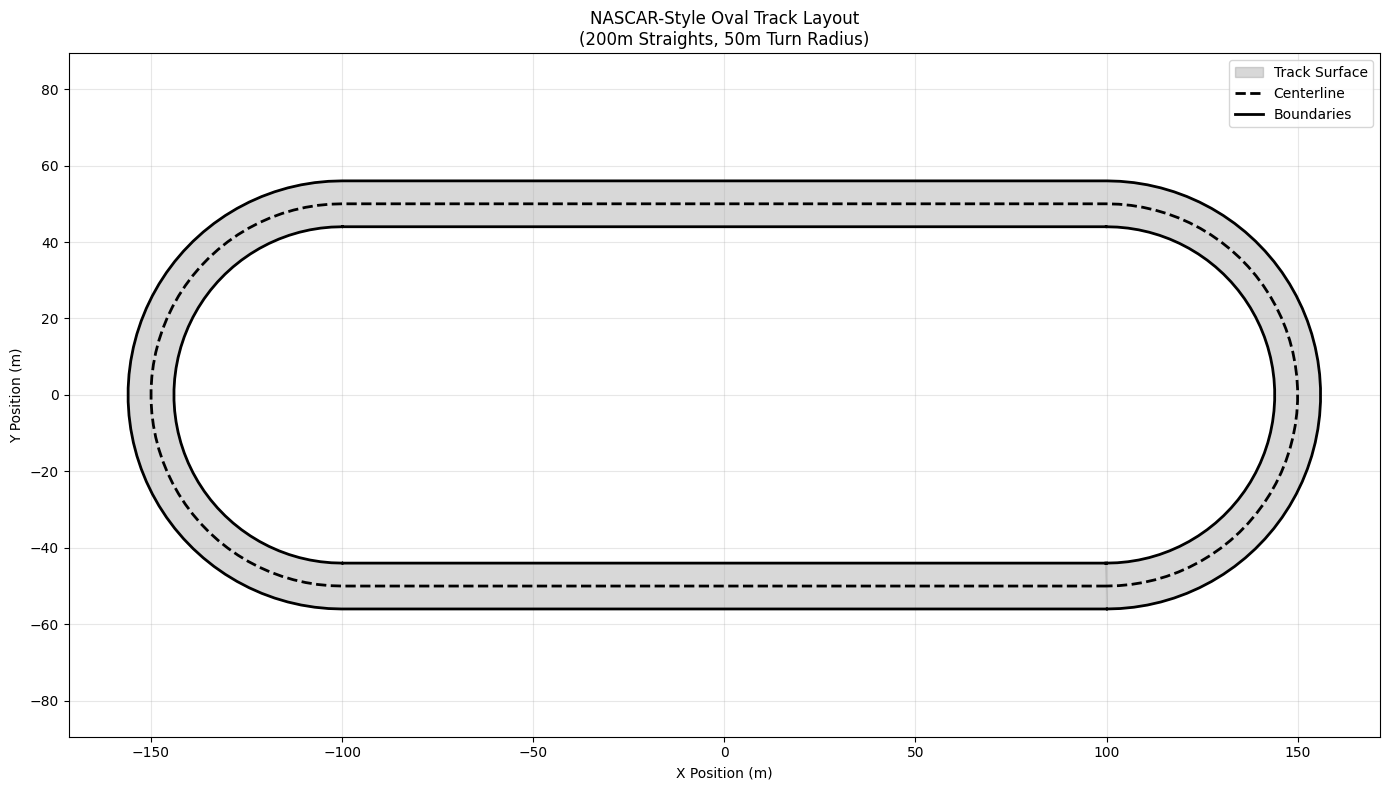

✓ Step 1 Complete: NASCAR oval track generated
  - Straight length: 200m
  - Turn radius: 50m
  - Track width: 12m


In [2]:
import numpy as np
import matplotlib.pyplot as plt

# ==========================================
# STEP 1: CREATE NASCAR-STYLE OVAL TRACK
# ==========================================

def create_nascar_oval():
    """
    Generate a proper NASCAR-style oval track with straights and semicircular ends
    """
    # Track parameters (meters)
    straight_length = 200      # Length of straight sections
    turn_radius = 50           # Radius of turns
    track_width = 12           # Standard NASCAR track width
    
    # Generate points for the centerline
    # Right straight (bottom)
    t_straight = np.linspace(0, 1, 50)
    right_straight_x = straight_length/2 - t_straight * straight_length
    right_straight_y = np.full_like(right_straight_x, -turn_radius)
    
    # Left turn (semicircle)
    t_turn = np.linspace(-np.pi/2, np.pi/2, 50)
    left_turn_x = np.full_like(t_turn, -straight_length/2) - turn_radius * np.cos(t_turn)
    left_turn_y = turn_radius * np.sin(t_turn)
    
    # Left straight (top)
    left_straight_x = -straight_length/2 + t_straight * straight_length
    left_straight_y = np.full_like(left_straight_x, turn_radius)
    
    # Right turn (semicircle)
    t_turn2 = np.linspace(np.pi/2, 3*np.pi/2, 50)
    right_turn_x = np.full_like(t_turn2, straight_length/2) - turn_radius * np.cos(t_turn2)
    right_turn_y = turn_radius * np.sin(t_turn2)
    
    # Combine all sections
    center_x = np.concatenate([right_straight_x, left_turn_x, left_straight_x, right_turn_x])
    center_y = np.concatenate([right_straight_y, left_turn_y, left_straight_y, right_turn_y])
    
    # Calculate normals for boundary generation
    dx = np.gradient(center_x)
    dy = np.gradient(center_y)
    norm = np.sqrt(dx**2 + dy**2)
    nx, ny = -dy/norm, dx/norm  # Normal vectors (perpendicular to direction)
    
    # Inner and outer boundaries (offset by track width)
    inner_x = center_x - nx * track_width/2
    inner_y = center_y - ny * track_width/2
    outer_x = center_x + nx * track_width/2
    outer_y = center_y + ny * track_width/2
    
    return {
        'center_x': center_x, 'center_y': center_y,
        'inner_x': inner_x, 'inner_y': inner_y,
        'outer_x': outer_x, 'outer_y': outer_y,
        'track_width': track_width
    }

track = create_nascar_oval()

# Visualize the track properly
plt.figure(figsize=(14, 8))

# Create filled track surface using polygon
# Combine outer boundary and reversed inner boundary to make a closed polygon
track_x = np.concatenate([track['outer_x'], track['inner_x'][::-1]])
track_y = np.concatenate([track['outer_y'], track['inner_y'][::-1]])

plt.fill(track_x, track_y, color='gray', alpha=0.3, label='Track Surface')
plt.plot(track['center_x'], track['center_y'], 'k--', linewidth=2, label='Centerline')
plt.plot(track['inner_x'], track['inner_y'], 'k-', linewidth=2, label='Boundaries')
plt.plot(track['outer_x'], track['outer_y'], 'k-', linewidth=2)

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.title('NASCAR-Style Oval Track Layout\n(200m Straights, 50m Turn Radius)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('track_layout.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Step 1 Complete: NASCAR oval track generated")
print(f"  - Straight length: 200m")
print(f"  - Turn radius: 50m")
print(f"  - Track width: {track['track_width']}m")

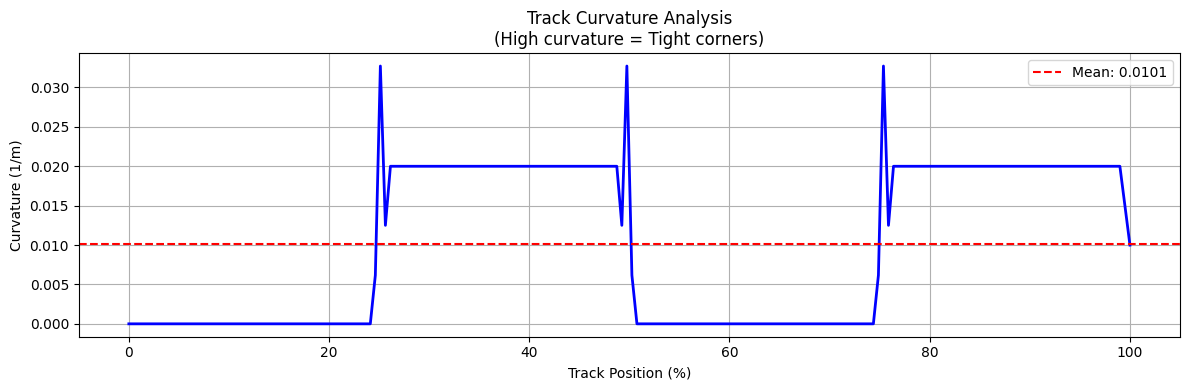

✓ Step 2 Complete: Curvature calculated (Max: 0.0327 1/m)


In [3]:
# ==========================================
# STEP 2: CALCULATE CURVATURE OF CENTERLINE
# ==========================================

def calculate_curvature(x, y):
    """Calculate curvature at each point using numerical derivatives"""
    dx = np.gradient(x)
    dy = np.gradient(y)
    ddx = np.gradient(dx)
    ddy = np.gradient(dy)
    
    curvature = np.abs(dx * ddy - dy * ddx) / (dx**2 + dy**2)**1.5
    return curvature

curvature = calculate_curvature(track['center_x'], track['center_y'])

# Plot curvature profile
plt.figure(figsize=(12, 4))
plt.plot(np.linspace(0, 100, len(curvature)), curvature, 'b-', linewidth=2)
plt.xlabel('Track Position (%)')
plt.ylabel('Curvature (1/m)')
plt.title('Track Curvature Analysis\n(High curvature = Tight corners)')
plt.grid(True)
plt.axhline(y=np.mean(curvature), color='r', linestyle='--', label=f'Mean: {np.mean(curvature):.4f}')
plt.legend()
plt.tight_layout()
plt.savefig('curvature_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Step 2 Complete: Curvature calculated (Max: {np.max(curvature):.4f} 1/m)")

In [ ]:
# ==========================================
# STEP 3: SIMPLE RACING LINE OPTIMIZATION
# ==========================================

def optimize_racing_line_simple(track, alpha=0.5):
    """
    Simple racing line optimization using curvature minimization
    alpha: weighting factor (0 = centerline, 1 = maximum curvature reduction)
    """
    cx, cy = track['center_x'], track['center_y']
    inner_x, inner_y = track['inner_x'], track['inner_y']
    outer_x, outer_y = track['outer_x'], track['outer_y']
    
    n_points = len(cx)
    
    # Calculate direction from center to boundaries
    dx_in = inner_x - cx
    dy_in = inner_y - cy
    dx_out = outer_x - cx
    dy_out = outer_y - cy
    
    # Simple heuristic: move toward outside of high curvature corners
    # This is a simplified version of minimum curvature optimization
    
    racing_x = np.zeros(n_points)
    racing_y = np.zeros(n_points)
    
    for i in range(n_points):
        # Determine if this is a corner (high curvature)
        is_corner = curvature[i] > np.percentile(curvature, 75)
        
        if is_corner:
            # In corners, take wider line (move toward outside)
            # Use outer boundary for high curvature sections
            racing_x[i] = cx[i] + alpha * (outer_x[i] - cx[i]) * 0.7
            racing_y[i] = cy[i] + alpha * (outer_y[i] - cy[i]) * 0.7
        else:
            # On straights, stay near center or hug inside for shorter path
            racing_x[i] = cx[i] + alpha * (inner_x[i] - cx[i]) * 0.3
            racing_y[i] = cy[i] + alpha * (inner_y[i] - cy[i]) * 0.3
    
    return racing_x, racing_y

# Generate optimized racing line
racing_x, racing_y = optimize_racing_line_simple(track, alpha=0.8)

# Calculate improvement
racing_curvature = calculate_curvature(racing_x, racing_y)
improvement = (np.mean(curvature) - np.mean(racing_curvature)) / np.mean(curvature) * 100

# Visualize comparison
plt.figure(figsize=(12, 10))

# Main track view
plt.subplot(2, 1, 1)
plt.fill_between(track['center_x'], track['inner_y'], track['outer_y'], 
                 alpha=0.2, color='gray')
plt.plot(track['inner_x'], track['inner_y'], 'k-', linewidth=1, alpha=0.5)
plt.plot(track['outer_x'], track['outer_y'], 'k-', linewidth=1, alpha=0.5)
plt.plot(track['center_x'], track['center_y'], 'b--', linewidth=2, label='Centerline', alpha=0.7)
plt.plot(racing_x, racing_y, 'r-', linewidth=3, label='AI Optimized Racing Line')
plt.scatter(racing_x[::10], racing_y[::10], c='red', s=30, zorder=5)

# Highlight corners
corner_idx = np.where(curvature > np.percentile(curvature, 75))[0]
if len(corner_idx) > 0:
    plt.scatter(track['center_x'][corner_idx], track['center_y'][corner_idx], 
                c='yellow', s=50, alpha=0.5, label='High Curvature Zones')

plt.axis('equal')
plt.grid(True, alpha=0.3)
plt.title('Racing Line Optimization Results')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend(loc='upper right')

# Curvature comparison
plt.subplot(2, 1, 2)
x_pos = np.linspace(0, 100, len(curvature))
plt.plot(x_pos, curvature, 'b--', linewidth=2, label=f'Centerline (Mean: {np.mean(curvature):.4f})', alpha=0.7)
plt.plot(x_pos, racing_curvature, 'r-', linewidth=2, label=f'Optimized (Mean: {np.mean(racing_curvature):.4f})')
plt.fill_between(x_pos, curvature, racing_curvature, 
                 where=(curvature > racing_curvature), alpha=0.3, color='green', label='Improvement')
plt.xlabel('Track Position (%)')
plt.ylabel('Curvature (1/m)')
plt.title(f'Curvature Reduction: {improvement:.1f}% improvement in corners')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('racing_line_optimization.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✓ Step 3 Complete: Racing line optimized")
print(f"  - Curvature reduction: {improvement:.1f}%")
print(f"  - Smoother trajectory through {len(corner_idx)} high-curvature zones")